# TFLITE generation for unity application

In [1]:
import os
import time
import tempfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
from tensorflow.python.platform import gfile
from keras.datasets import cifar10
from keras.optimizers import SGD,Adam
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [3]:
from tensorflow.python.client import device_lib

* Device check (whether using cpu or gpu)

In [4]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17106553863584185418
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 5717884928
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 1413743525632410302
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:01:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

In [ ]:
# gpus = tf.config.list_physical_devices('GPU')
# print(gpus)

In [ ]:
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

-----------

## Current Project summary

* current model is coco_ssd_mobilenet
* (https://github.com/asus4/tf-lite-unity-sample)
* It follows object detection supported from tensorflow
* (https://www.tensorflow.org/lite/models/object_detection/overview)

-------

## Training dataset load

* Here, we are going to use CIFAR-10 dataset for simple testing

In [5]:
# Load dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=.3)

In [6]:
#Print the dimensions of the datasets

print((x_train.shape,y_train.shape))
print((x_val.shape,y_val.shape))
print((x_test.shape,y_test.shape))

((35000, 32, 32, 3), (35000, 1))
((15000, 32, 32, 3), (15000, 1))
((10000, 32, 32, 3), (10000, 1))


In [7]:
# Normalizing
# x_train=x_train / 255.0
# x_test=x_test / 255.0

x_train=x_train.astype(np.float32) / 255.0
x_test=x_test.astype(np.float32) / 255.0

#One hot encoding
y_train_cat=to_categorical(y_train,10)
y_test_cat=to_categorical(y_test,10)

In [8]:
## Visualization for sample training dataset image
# img = plt.imshow(x_train[1])

---------------

## Prepare the detection model

* Here, we try transfer learning, starting from pre-trained model "MobileNetV2"

In [9]:
## importing original MobileNetV2 model
from keras.applications.mobilenet_v2 import MobileNetV2

In [20]:
## Reorganizing the MobileNetV2 model for our own custom dataset
## and be ready for the transfer learning
# base_model = MobileNetV2(weights='imagenet') ## loading original MobileNetV2 model
base_model = MobileNetV2(
    input_shape = (32,32,3),         # input image resolution
    alpha = 1.0,                     # float, larger than zero, controls the width of the network
    include_top = False,             # whether to include the fully-connected layer at the top of the network.
    weights= 'imagenet',             # None(random initialization), 'imagenet'(pre-training of ImageNet) or the path to the weights
    input_tensor = None,             # optional keras tensor to use as image input
    pooling = None,                  # optional pooling mode for feature extraction (None, avg, max)
    # classes = y_train.shape[1],      # integer number of classes to classify images into
    # classifier_activation='softmax'  # activation function to use on the "top" layer
)

In [21]:
## Check the overall architecture of the base model(mobilenetv2)
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 16, 16, 32)   864         ['input_2[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 16, 16, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 16, 16, 32)   0           ['bn_Conv1[0][0]']               
                                                                               

In [22]:
#Adding layers to base model of MobileNet

model = Sequential()

#Creating base layer of VGG19
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())

#Adding the Dense Layers and Dropout
model.add(Dense(512,activation=('relu'))) 
model.add(Dense(256,activation=('relu'))) 
model.add(Dropout(.3))
model.add(Dense(128,activation=('relu')))
model.add(Dropout(.2))
model.add(Dense(10,activation=('softmax')))

In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1, 1, 1280)       2257984   
 ional)                                                          
                                                                 
 dropout_3 (Dropout)         (None, 1, 1, 1280)        0         
                                                                 
 flatten_1 (Flatten)         (None, 1280)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               655872    
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                      

In [24]:
#Compiling Model using SGD 

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [25]:
## Setting my own Callback system
## Adjusting EarlyStopping supported by keras
AndrewCallback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',           # quantity to be monitored
    # min_delta=0,                  # minimum change in the monitored quantity to qualify as an improvement
    patience=5,                   # number of epochs with no improvement
    verbose=1,                    # 0 is silent, 1 displays messages
    mode='auto',                  # auto / min: will stop monitored has stopped decreasing / max: stop when monitored has stopped increasing
    # baseline=None,                # baseline value
    restore_best_weights=True,    # whether to restore model weights from the epoch with the best value of the monitored quantity
    # start_from_epoch=0            # numberof epochs to wait before starting to monitor improvement
)

In [26]:
#Training Model
with tf.device('/device:GPU:0'):
    hist = model.fit(x_train, y_train_cat, batch_size = 100, epochs = 20, validation_split = 0.1, callbacks= AndrewCallback)

Epoch 1/20
315/315 [==============================] - 12s 27ms/step - loss: 1.5738 - accuracy: 0.4626 - val_loss: 2.5685 - val_accuracy: 0.2497
Epoch 2/20
315/315 [==============================] - 8s 25ms/step - loss: 1.0155 - accuracy: 0.6787 - val_loss: 2.8904 - val_accuracy: 0.3991
Epoch 3/20
315/315 [==============================] - 8s 25ms/step - loss: 0.8459 - accuracy: 0.7323 - val_loss: 2.2947 - val_accuracy: 0.4449
Epoch 4/20
315/315 [==============================] - 7s 24ms/step - loss: 0.7433 - accuracy: 0.7653 - val_loss: 1.5794 - val_accuracy: 0.5794
Epoch 5/20
315/315 [==============================] - 7s 23ms/step - loss: 0.6698 - accuracy: 0.7909 - val_loss: 1.5239 - val_accuracy: 0.5677
Epoch 6/20
315/315 [==============================] - 7s 23ms/step - loss: 0.6101 - accuracy: 0.8096 - val_loss: 1.6451 - val_accuracy: 0.6249
Epoch 7/20
315/315 [==============================] - 7s 23ms/step - loss: 0.5795 - accuracy: 0.8147 - val_loss: 2.4377 - val_accuracy: 0.542

In [27]:
#Testing accuracy of trained model
with tf.device('/device:GPU:0'):
    model.evaluate(x_test, y_test_cat)[1]

313/313 [==============================] - 4s 10ms/step - loss: 1.5245 - accuracy: 0.5674


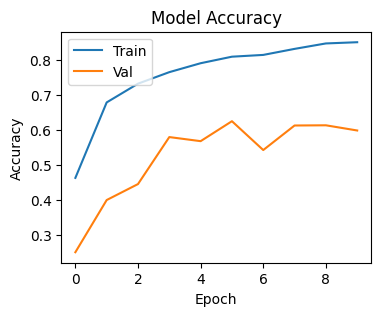

In [34]:
## Visualizing Model Accuracy
fig = plt.figure(figsize=(4,3))
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc = 'upper left')

-----------

## Saving the model

In [36]:
## check the current model path (where pb file saved)
model.save('C:/Users/user/Jupyter/ML_practices/Tensorflow_prac/SSD_object_detection/retrained_model') #path and name

INFO:tensorflow:Assets written to: C:/Users/user/Jupyter/ML_practices/Tensorflow_prac/SSD_object_detection/retrained_model\assets


INFO:tensorflow:Assets written to: C:/Users/user/Jupyter/ML_practices/Tensorflow_prac/SSD_object_detection/retrained_model\assets


----------

## Converting the pb model into tflite file

In [37]:
## load pb model
model_path = 'C:/Users/user/Jupyter/ML_practices/Tensorflow_prac/SSD_object_detection/retrained_model/'
saved_model = tf.saved_model.load(model_path)

In [38]:
saved_model

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x209ea9a7970>

* Setting the converter

In [ ]:
# def representative_data_gen():
#     for input_value in tf.data.Dataset.from_tensor_slices(x_train).batch(1).take(100):
#         yield [input_value]

In [39]:
def representative_dataset():
    for _ in range(100):
        data = np.random.rand(1, 32, 32, 3)
        yield [data.astype(np.float32)]

In [42]:
## Converter without using representative_dataset(simple)
# converter = tf.lite.TFLiteConverter.from_saved_model(model_path) # path to the SavedModel directory
# converter.optimizations = [tf.lite.Optimize.DEFAULT]

## Converter using representative_dataset
converter = tf.lite.TFLiteConverter.from_saved_model(model_path) # path to the SavedModel directory
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset

* Convert the saved pb model into tflite format

In [43]:
tflite_model = converter.convert()

* Save the tflite model into the path

In [44]:
open('C:/Users/user/Jupyter/ML_practices/Tensorflow_prac/SSD_object_detection/retrained_model/ssd_model.tflite', "wb").write(tflite_model)

3537936